In [77]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

# Konkurser

I denne analysen bruker jeg data knyttet til konkurser basert på type næring, kommune og politisk sammensetning.

In [39]:
df_enh = pd.read_parquet('data/enheter.parquet')
df_kart = gpd.read_parquet('data/kart.parquet')
df_naering = pd.read_parquet('data/naeringskoder.parquet')
df_valg = pd.read_parquet('data/valg2019.parquet')

In [4]:
df_enh.columns,df_kart.columns,df_naering.columns,df_valg.columns

(Index(['organisasjonsnummer', 'organisasjonsform', 'navn', 'kommune',
        'kommunenummer', 'stiftelsesdato', 'konkurs', 'underAvvikling',
        'underTvangsavviklingEllerTvangsopplosning', 'naeringskode1',
        'naeringskode2', 'naeringskode3'],
       dtype='object'),
 Index(['geometry', 'kommunenummer', 'navn', 'areal'], dtype='object'),
 Index(['code', 'level', 'shortName'], dtype='object'),
 Index(['kommunenummer', 'kommunenavn', 'Arbeiderpartiet', 'Fremskrittspartiet',
        'Høyre', 'Kristelig Folkeparti', 'Miljøpartiet de Grønne', 'Rødt',
        'Senterpartiet', 'Sosialistisk Venstreparti', 'Venstre'],
       dtype='object'))

## Konkurser per næringsgruppe

In [5]:
df_konkurs = df_enh[df_enh.konkurs]

In [6]:
len(df_konkurs) / len(df_enh)

0.003012664012796305

In [7]:
len(df_konkurs), len(df_konkurs) / len(df_enh) 

print(f"{100 * len(df_konkurs)/len(df_enh):.2f}% ({len(df_konkurs)}) av alle enheter gikk konkurs den siste perioden")

0.30% (3006) av alle enheter gikk konkurs den siste perioden


In [8]:
def merge_economic_activity_code(df, df_code, right_index=False, right_on=None):
    return df_code[['code', 'shortName']].merge(df, left_on='code', right_index=right_index, right_on=right_on).sort_values('count', ascending=False)

def economic_activity_count(df, df_code):
    """telle opp enheter basert på næringskode (level 2)"""
    df = df[['naeringskode1',
        'naeringskode2', 'naeringskode3']].apply(lambda x: (x.str.split('.').str[0]), axis=1)
    
    # her teller noen bedrifter potensielt som 3, dette kunne normaliseres 
    df = (
        df.naeringskode1.value_counts().add(
            df.naeringskode2.value_counts().add(
                df.naeringskode3.value_counts(),
                fill_value=0,
            ),
            fill_value=0,
        )
    )
    return merge_economic_activity_code(df, df_code, right_index=True)
    

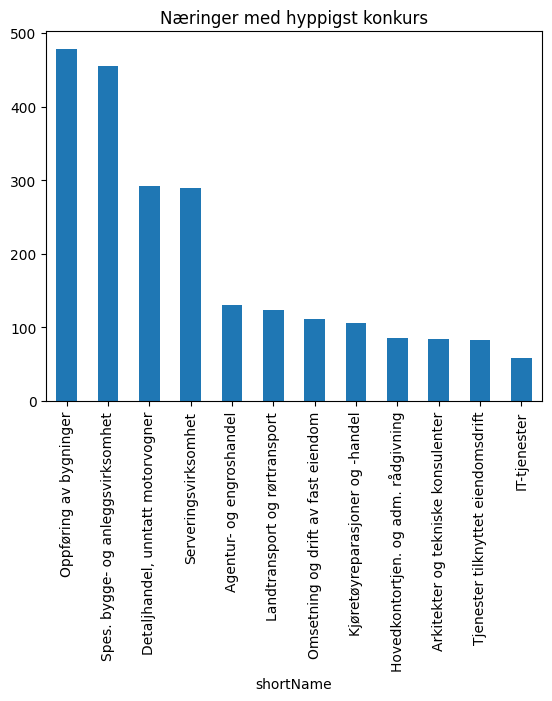

In [9]:
konkurs_per_naering = economic_activity_count(df_konkurs, df_naering)
ax = konkurs_per_naering.head(12).plot.bar(x='shortName', y='count', rot=90, title="Næringer med hyppigst konkurs", legend=None)

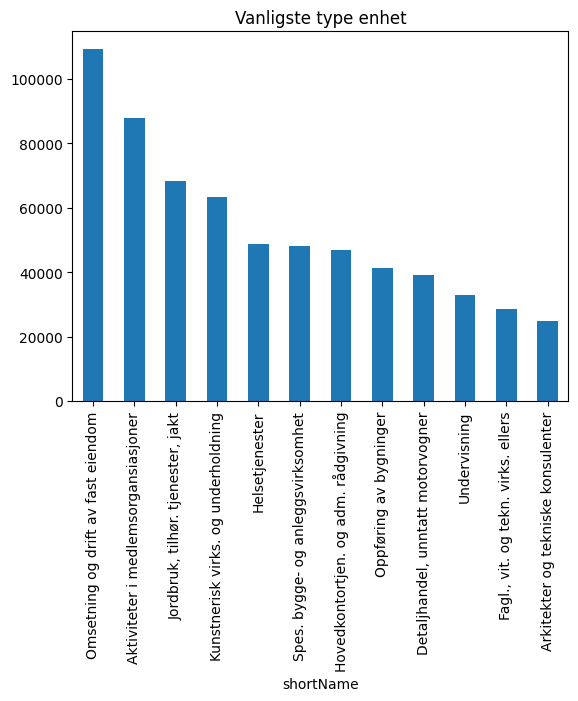

In [10]:
enheter_per_naering = economic_activity_count(df_enh, df_naering)
ax = enheter_per_naering.head(12).plot.bar(x='shortName', y='count', rot=90, title="Vanligste type enhet", legend=None)


[Text(0.5, 25.722222222222214, '')]

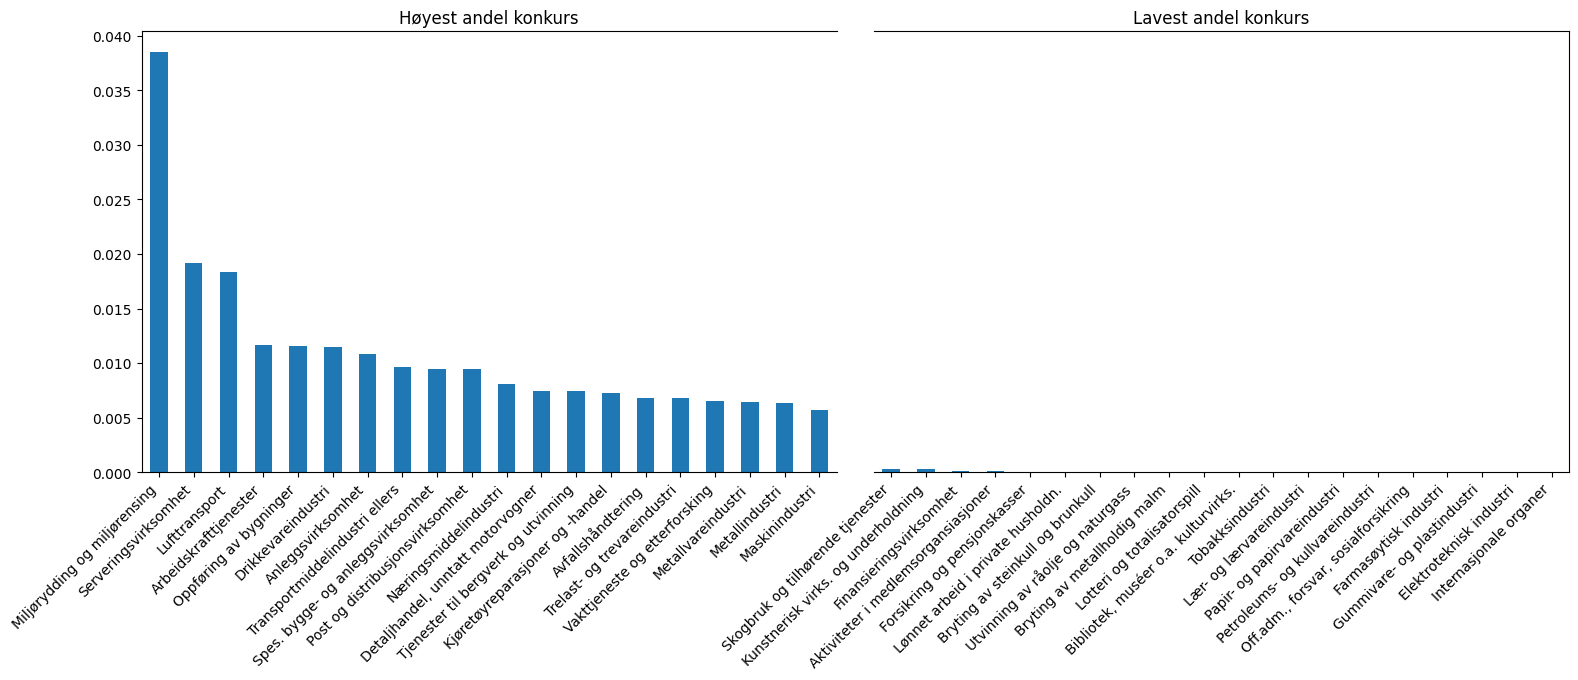

In [11]:
konkurs_andel = merge_economic_activity_code(
    konkurs_per_naering.set_index('code')['count'].div(enheter_per_naering.set_index('code')['count'], fill_value=0).sort_values(ascending=False),
    df_naering,
    right_index=True,
)

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
plt.tight_layout()
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].tick_params(axis='y', which='both', length=0)
konkurs_andel.head(20).plot.bar(x='shortName', y='count', title="Høyest andel konkurs", legend=None, ax=ax[0]) 
konkurs_andel.tail(20).plot.bar(x='shortName', y='count', title="Lavest andel konkurs", legend=None, ax=ax[1])
ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation=45, ha='right')
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation=45, ha='right')
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)

## Konkurser i kommuner

In [12]:
def municipality_count(df, df_municipality):
    return df_municipality.merge(df.kommunenummer.value_counts(), left_on='kommunenummer', right_index=True).fillna(0).sort_values('count', ascending=False)

In [13]:
konkurs_per_kommune = municipality_count(df_konkurs, df_kart)

Text(0.5, 0, 'kommune')

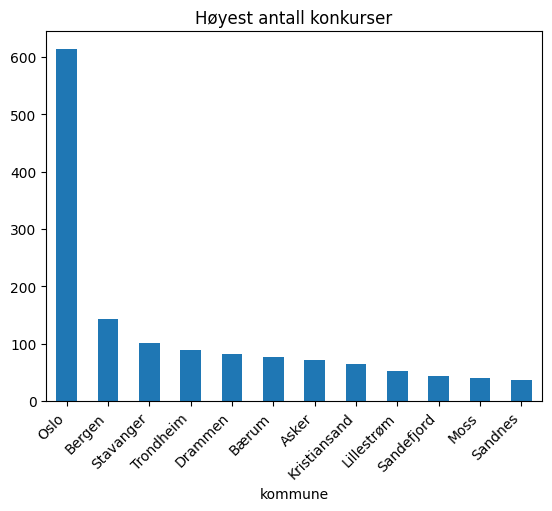

In [158]:
ax = konkurs_per_kommune.head(12).plot.bar(x='navn', y='count', title="Høyest antall konkurser", legend=None)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('kommune')


[Text(0.5, 0, '')]

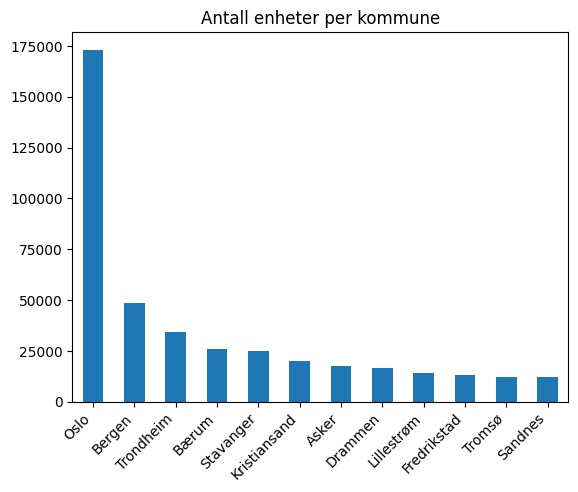

In [15]:
enheter_per_kommune = municipality_count(df_enh, df_kart)
ax = enheter_per_kommune.head(12).plot.bar(x='navn', y='count',title="Antall enheter per kommune", legend=None)
plt.xticks(rotation=45, ha='right')
ax.set(xlabel=None)

In [16]:
kommunenummer_flest_enheter = enheter_per_kommune.head(12).kommunenummer

In [17]:
def plot_lines(ax, series, colors):
    plt_stuff = {
        'mean (micro)': getattr(series, 'mean'),
        'median': partial(getattr(series, 'quantile'), q=.50),
        '1st quartile': partial(getattr(series, 'quantile'), q=.25),
        '3rd quartile': partial(getattr(series, 'quantile'), q=.75),
    }
    for (name, func), color in zip(plt_stuff.items(), colors):
        ax.hlines(y=func(), xmin=-1, xmax=12, colors=color, linestyles=':', label=name)


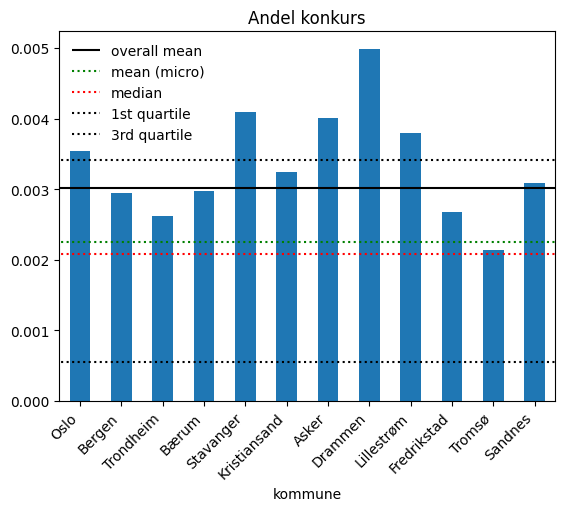

In [18]:
konkurs_andel_kommune = df_kart.merge(
    konkurs_per_kommune
        .set_index('kommunenummer')['count']
    .div(enheter_per_kommune
         .set_index('kommunenummer')['count'], fill_value=0)
    .sort_values(ascending=False),
    left_on='kommunenummer',
    right_index=True
).sort_values('count', ascending=False)

ax = konkurs_andel_kommune.loc[kommunenummer_flest_enheter.index].plot.bar(x='navn', y='count', title="Andel konkurs", legend=None) 
plt.xticks(rotation=45, ha='right')
ax.set(xlabel='kommune')


ax.hlines(y=len(df_konkurs)/len(df_enh), xmin=-1, xmax=12, colors='k', label='overall mean')
plot_lines(ax, konkurs_andel_kommune['count'], ['g', 'r', 'k', 'k'])
handles, labels = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(handles = handles[:-1], labels = labels[:-1], frameon=False)

Ved å sammenligne snittet av konkursandel med snitt av konkurser fra plottet ser vi at kommunene med flest enheter oftere har høyere andel konkurser

<Axes: >

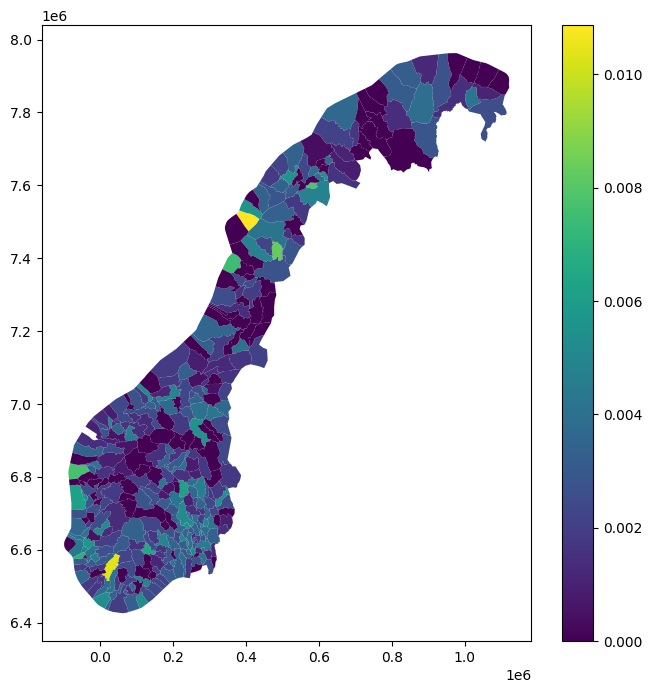

In [24]:
konkurs_andel_kommune.plot(column='count', legend=True, figsize=(8,8))

In [51]:
# kommune_konkurs_andel_valg = konkurs_andel_kommune.merge(df_valg, left_on='kommunenummer', right_on='kommunenummer').drop(['kommunenavn'], axis=1)
kommune_konkurs_andel_valg = konkurs_andel_kommune.merge(df_valg, on='kommunenummer').drop(['kommunenavn'], axis=1)

<Axes: >

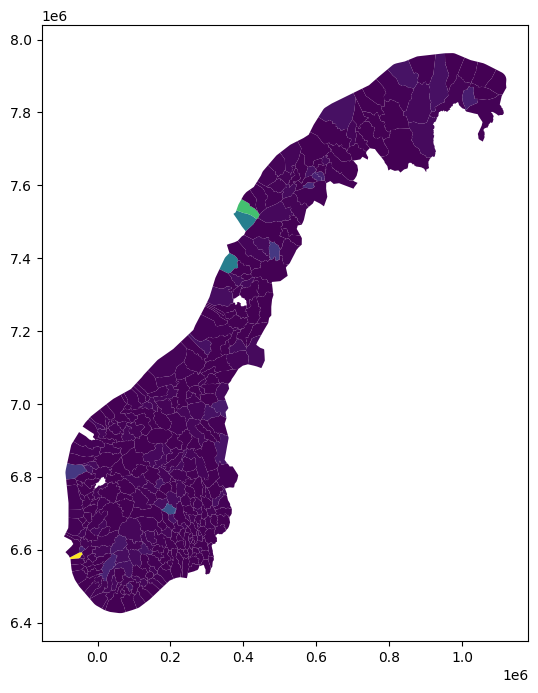

In [52]:
kommune_konkurs_andel_valg.plot(column=kommune_konkurs_andel_valg['count']/kommune_konkurs_andel_valg['stemmer_totalt'], figsize=(8,8))

Her er det høyt utslag i noen få kommuner. Disse har hatt spesielt mange konkurser i det siste i forhold til befolkningen. Samtidig vil det her også typisk være mye støy gitt at vi kun har 10x flere konkurser enn vi har kommuner.

## Konkurser i kommuner basert på politisk dreining

In [57]:
party_names = ['Arbeiderpartiet', 'Fremskrittspartiet', 'Høyre',
       'Kristelig Folkeparti', 'Miljøpartiet de Grønne', 'Rødt',
       'Senterpartiet', 'Sosialistisk Venstreparti', 'Venstre']

In [107]:
X_ = kommune_konkurs_andel_valg[party_names].values
y_ = kommune_konkurs_andel_valg['count'].values
nonzero_idx = y.nonzero()[0] # I choose to not include places where bankrupt ratio is zero
X = X_[nonzero_idx]
y = y_[nonzero_idx]

In [108]:
# based on https://www.justintodata.com/explainable-machine-learning-with-python/
import xgboost as xgb
from sklearn.inspection import permutation_importance

In [121]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)
model.fit(X, y)
pass

sort_idx = y.argsort()
x = np.arange(y.size)
plt.plot(x,y,x,model.predict(X))

<Axes: >

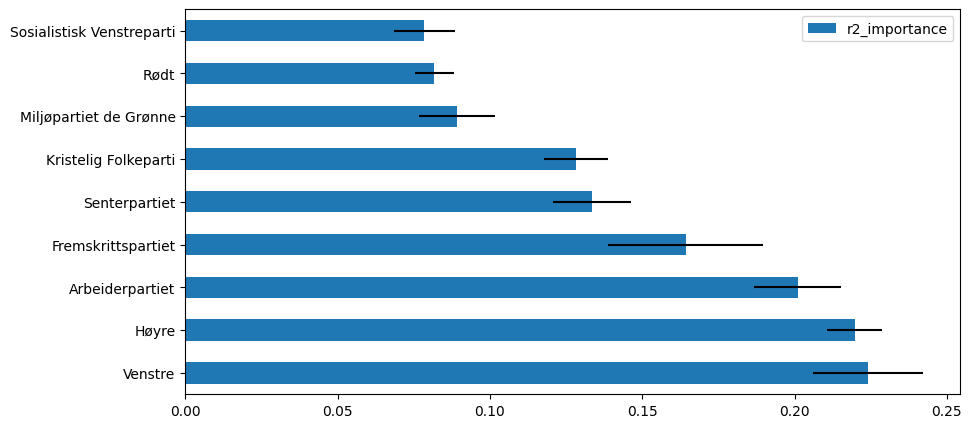

In [129]:
perm_importance = permutation_importance(model, X, y, scoring=['r2'], n_repeats=5, random_state=42)
pd.DataFrame(
    dict(
        r2_importance=perm_importance['r2']['importances_mean'],
        r2_std=perm_importance['r2']['importances_std'],
    ),
    index=party_names
).sort_values(by='r2_importance', ascending=False).plot.barh(figsize=(10, 5), xerr='r2_std')

In [ ]:
# variansen kan forklares med mest med venstre og høyre velgere

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


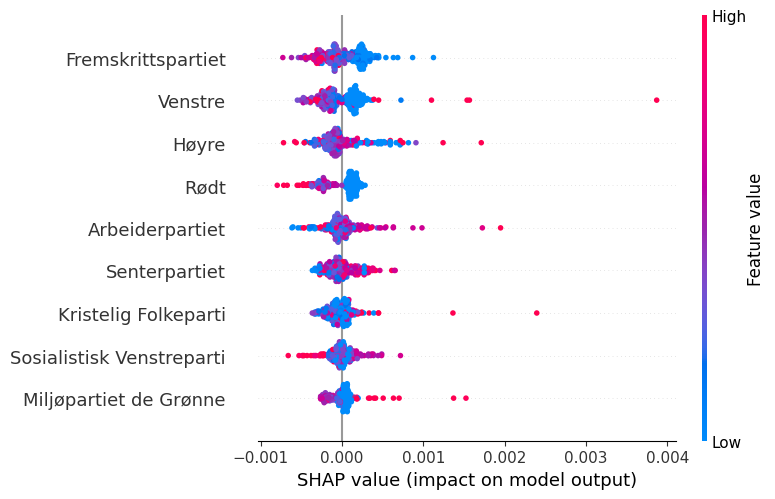

In [156]:
import shap
np.float = np.float_
np.int = np.int_
np.bool = np.bool_ # hack to deal with shap using deprecated types
explainer = shap.TreeExplainer(model)
shap_values = explainer(kommune_konkurs_andel_valg[party_names].iloc[nonzero_idx])
shap.summary_plot(shap_values, kommune_konkurs_andel_valg[party_names].iloc[nonzero_idx])
# farge: stor input verdien var
# shap: hvilken retning den trakk prediksjonen
# y: høy=viktig feature, lav= mindre viktig

Om få stemmer på FrP, SV eller Rødt, og mange stemmer Sp, Mdg eller Venstre er dette korrelert med høyere andel konkurser.

Ap, KrF og Høyre har mindre tydelig utslag på modellen.